In [ ]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted")

Fontes de Dados:

In [ ]:
df_glassdoor = pd.read_csv("/content/Glassdor-DataScientist.csv")
df_indeed = pd.read_csv("/content/Indeed-Data Science Jobs List.csv")
df_linkedin = pd.read_csv("/content/Linkedin-clean_jobs.csv")

# Visualização inicial
df_linkedin.head(2), df_glassdoor.head(2), df_indeed.head(2)

(   id         title company           location  \
 0   1  Data Analyst    Meta       New York, NY   
 1   2  Data Analyst    Meta  San Francisco, CA   
 
                                                 link    source date_posted  \
 0  https://www.linkedin.com/jobs/view/data-analys...  LinkedIn  2025-04-14   
 1  https://www.linkedin.com/jobs/view/data-analys...  LinkedIn  2025-04-14   
 
    work_type  employment_type  \
 0        NaN              NaN   
 1        NaN              NaN   
 
                                          description  
 0  The Social Measurement team is a growing team ...  
 1  The Social Measurement team is a growing team ...  ,
    Unnamed: 0  index                          Job Title  \
 0           0      0              Senior Data Scientist   
 1           1      1  Data Scientist, Product Analytics   
 
                 Salary Estimate  \
 0  $111K-$181K (Glassdoor est.)   
 1  $111K-$181K (Glassdoor est.)   
 
                                      Job

In [ ]:
print("LinkedIn columns:")
print(df_linkedin.columns.tolist())

print("\nGlassdoor columns:")
print(df_glassdoor.columns.tolist())

print("\nIndeed columns:")
print(df_indeed.columns.tolist())

LinkedIn columns:
['id', 'title', 'company', 'location', 'link', 'source', 'date_posted', 'work_type', 'employment_type', 'description']

Glassdoor columns:
['Unnamed: 0', 'index', 'Job Title', 'Salary Estimate', 'Job Description', 'Rating', 'Company Name', 'Location', 'Headquarters', 'Size', 'Founded', 'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors', 'Easy Apply']

Indeed columns:
['Position', 'Job Title', 'Company', 'Location', 'Salary', 'Short Description', 'Posted At', 'Job link']


In [1]:
# Requisição da API JSearch API

url = "https://jsearch.p.rapidapi.com/search"
querystring = {"query": "data analyst", "num_pages": "1"}

headers = {
    "X-RapidAPI-Key": "db6c66d720mshc6564ca746f9a3cp1d5e10jsn1aa991b81eb6",
    "X-RapidAPI-Host": "jsearch.p.rapidapi.com"
}

response = requests.get(url, headers=headers, params=querystring)
data = response.json()

# Dataframe API
df_api = pd.json_normalize(data["data"])
print(df_api.columns)
df_api.head()

NameError: name 'requests' is not defined

Limpeza e Unificação dos Dados:

In [ ]:
def clean_linkedin(df):
    df = df.rename(columns=str.lower)
    df = df.rename(columns={
        "work_type": "employment_type"
    })

    df["salary"] = np.nan
    df["source"] = "LinkedIn"

    df = df.drop_duplicates()
    return df[[
        "title", "company", "employment_type", "description",
        "location", "date_posted", "salary",
        "link", "source"
    ]]

In [ ]:
def clean_glassdoor(df):
    df = df.rename(columns=str.lower)
    df = df.rename(columns={
        "job title": "title",
        "company name": "company",
        "job description": "description",
        "salary estimate": "salary"
    })

    df["employment_type"] = np.nan
    df["date_posted"] = np.nan
    df["link"] = np.nan
    df["source"] = "Glassdoor"

    df = df.drop_duplicates()
    return df[[
        "title", "company", "employment_type", "description",
        "location", "date_posted", "salary",
        "link", "source"
    ]]

In [ ]:
def clean_indeed(df):
    df = df.rename(columns=str.lower)
    df = df.rename(columns={
        "position": "title",
        "job title": "title",
        "short description": "description",
        "job link": "link",
        "posted at": "date_posted"
    })

    df["employment_type"] = np.nan
    df["source"] = "Indeed"

    df = df.drop_duplicates()
    return df[[
        "title", "company", "employment_type", "description",
        "location", "date_posted", "salary",
        "link", "source"
    ]]

In [ ]:
# Função para limpar e padronizar o df_api
def clean_dataset_api(df):
    df = df[[
        "job_title",
        "employer_name",
        "job_employment_type",
        "job_description",
        "job_location",
        "job_posted_at_datetime_utc",
        "job_salary",
        "job_apply_link",
    ]].rename(columns={
        "job_title": "title",
        "employer_name": "company",
        "job_employment_type": "employment_type",
        "job_description": "description",
        "job_location": "location",
        "job_posted_at_datetime_utc": "date_posted",
        "job_salary": "salary",
        "job_apply_link": "link",
    })

    df["source"] = "JSearch API"
    df = df.drop_duplicates()

    return df[[
        "title", "company", "employment_type", "description",
        "location", "date_posted", "salary",
        "link", "source"
    ]]

In [ ]:
def clean_common_columns(df):
    """
    Padroniza estrutura básica dos DataFrames:
    - Garante nomes de colunas em minúsculas e sem espaços extras
    - Remove colunas duplicadas
    - Reseta o índice
    - Retorna uma cópia limpa do DataFrame
    """
    df = df.copy()
    df.columns = df.columns.astype(str).str.strip().str.lower()
    df = df.loc[:, ~df.columns.duplicated()].copy()
    df.reset_index(drop=True, inplace=True)
    return df

In [ ]:
df_linkedin = clean_linkedin(df_linkedin)
df_glassdoor = clean_glassdoor(df_glassdoor)
df_indeed = clean_indeed(df_indeed)

In [ ]:
df_linkedin = clean_common_columns(df_linkedin)
df_glassdoor = clean_common_columns(df_glassdoor)
df_indeed = clean_common_columns(df_indeed)

In [ ]:
df_api = clean_dataset_api(df_api)

In [ ]:
df_unico = pd.concat([df_linkedin, df_glassdoor, df_indeed], ignore_index=True)
print(df_unico.shape)
df_unico.head()

(5157, 9)


,title,company,employment_type,description,location,date_posted,salary,link,source
0,Data Analyst,Meta,NaN,The Social Measurement team is a growing team ...,"New York, NY",2025-04-14,NaN,https://www.linkedin.com/jobs/view/data-analys...,LinkedIn
1,Data Analyst,Meta,NaN,The Social Measurement team is a growing team ...,"San Francisco, CA",2025-04-14,NaN,https://www.linkedin.com/jobs/view/data-analys...,LinkedIn
2,Data Analyst,Meta,NaN,The Social Measurement team is a growing team ...,"Los Angeles, CA",2025-04-14,NaN,https://www.linkedin.com/jobs/view/data-analys...,LinkedIn
3,Data Analyst,Meta,NaN,The Social Measurement team is a growing team ...,"Washington, DC",2025-04-14,NaN,https://www.linkedin.com/jobs/view/data-analys...,LinkedIn
4,Data Analyst II,Pinterest,NaN,About Pinterest\n\nMillions of people around t...,"Chicago, IL",2025-04-16,NaN,https://www.linkedin.com/jobs/view/data-analys...,LinkedIn


In [ ]:
# Selecionar as colunas e unificar tudo em um único DataFrame
cols_final = [
    "title", "company", "employment_type", "description",
    "location", "date_posted", "salary", "link", "source"
]

df_final = pd.concat(
    [df_linkedin[cols_final], df_glassdoor[cols_final],
     df_indeed[cols_final], df_api[cols_final]],
    ignore_index=True
).drop_duplicates()

print("\n Shape final:", df_final.shape)
df_final.head()


 Shape final: (5167, 9)


,title,company,employment_type,description,location,date_posted,salary,link,source
0,Data Analyst,Meta,NaN,The Social Measurement team is a growing team ...,"New York, NY",2025-04-14,NaN,https://www.linkedin.com/jobs/view/data-analys...,LinkedIn
1,Data Analyst,Meta,NaN,The Social Measurement team is a growing team ...,"San Francisco, CA",2025-04-14,NaN,https://www.linkedin.com/jobs/view/data-analys...,LinkedIn
2,Data Analyst,Meta,NaN,The Social Measurement team is a growing team ...,"Los Angeles, CA",2025-04-14,NaN,https://www.linkedin.com/jobs/view/data-analys...,LinkedIn
3,Data Analyst,Meta,NaN,The Social Measurement team is a growing team ...,"Washington, DC",2025-04-14,NaN,https://www.linkedin.com/jobs/view/data-analys...,LinkedIn
4,Data Analyst II,Pinterest,NaN,About Pinterest\n\nMillions of people around t...,"Chicago, IL",2025-04-16,NaN,https://www.linkedin.com/jobs/view/data-analys...,LinkedIn


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5167 entries, 0 to 5166
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            5167 non-null   object
 1   company          5165 non-null   object
 2   employment_type  10 non-null     object
 3   description      5163 non-null   object
 4   location         5152 non-null   object
 5   date_posted      1049 non-null   object
 6   salary           3971 non-null   object
 7   link             1258 non-null   object
 8   source           5167 non-null   object
dtypes: object(9)
memory usage: 363.4+ KB


 Análise Exploratória (EDA):

In [ ]:
# Estatísticas gerais
print(df_final.info())
print('\n Estatísticas gerais: \n', df_final.describe(include='all'))

# Contagem de vagas por fonte
print('\n Contagem de vagas por fonte: \n',df_final['source'].value_counts())

# Contagem de vagas por cidade
print('\n Contagem de vagas por cidade: \n',df_final['location'].value_counts().head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5167 entries, 0 to 5166
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            5167 non-null   object
 1   company          5165 non-null   object
 2   employment_type  10 non-null     object
 3   description      5163 non-null   object
 4   location         5152 non-null   object
 5   date_posted      1049 non-null   object
 6   salary           3971 non-null   object
 7   link             1258 non-null   object
 8   source           5167 non-null   object
dtypes: object(9)
memory usage: 363.4+ KB
None

 Estatísticas gerais: 
                title company employment_type  \
count           5167    5165              10   
unique          2763    2880               3   
top     Data Analyst    Meta       Full-time   
freq             398      70               8   

                                              description      location  \
count      

=== Cargos com maior número de vagas ===
title
data analyst                         404
data scientist                       352
data engineer                        323
senior data scientist                 93
machine learning engineer             68
senior data analyst                   59
senior data engineer                  50
big data engineer                     43
business intelligence analyst         43
data scientist, product analytics     31
lead data scientist                   24
research scientist                    24
junior data analyst                   23
sr. data scientist                    23
data engineer, product analytics      20
Name: count, dtype: int64


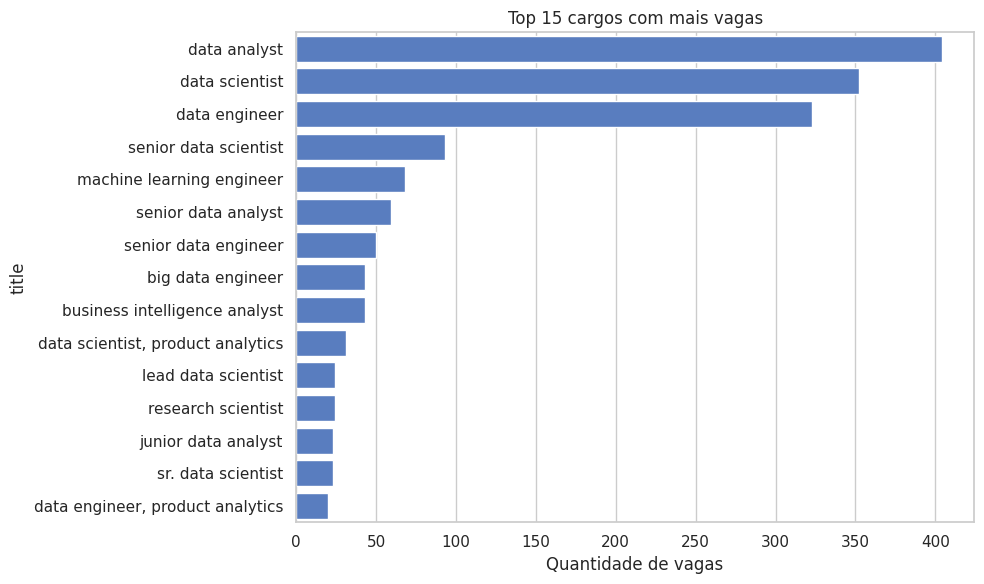

In [ ]:
# cargos mais comuns
top_titles = (
    df_final["title"]
    .dropna()
    .str.lower()
    .value_counts()
    .head(15)
)

print("=== Cargos com maior número de vagas ===")
print(top_titles)

# Gráfico
plt.figure(figsize=(10,6))
sns.barplot(x=top_titles.values, y=top_titles.index)
plt.title("Top 15 cargos com mais vagas")
plt.xlabel("Quantidade de vagas")
plt.tight_layout()
plt.show()

Top 15 skills mais citadas nas descrições:
python: 2769
sql: 2645
machine learning: 1749
statistics: 1592
r: 1524
data analysis: 1224
spark: 1032
tableau: 949
excel: 880
aws: 825
hadoop: 699
data visualization: 693
azure: 466
power bi: 417
deep learning: 364


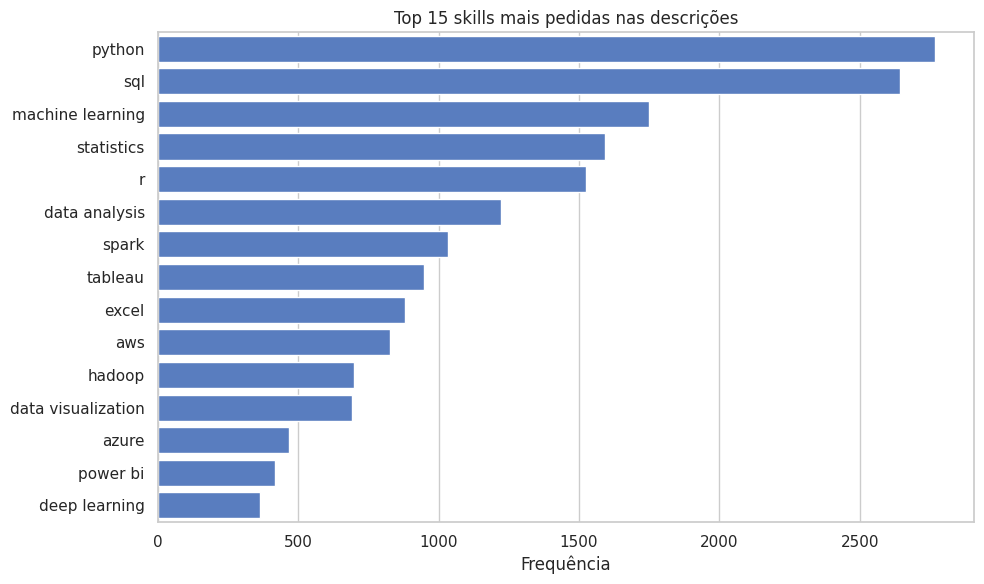

In [ ]:
# Lista de hard skills
skills_lista = [
    "python", "sql", "excel", "power bi", "tableau", "r", "aws", "azure",
    "spark", "hadoop", "machine learning", "deep learning", "statistics",
    "data analysis", "data visualization", "numpy", "pandas", "tensorflow",
    "pytorch", "google cloud", "databricks"
]

# Cria um contador
skill_counts = Counter()

# Percorre todas as descrições
for text in df_final["description"].dropna().astype(str):
    text = text.lower()
    for skill in skills_lista:
        # Verifica se a skill aparece como palavra isolada
        if re.search(rf"\b{re.escape(skill)}\b", text):
            skill_counts[skill] += 1

# Mostra as 15 skills mais frequentes
top_skills = skill_counts.most_common(15)

skills = [s for s, c in top_skills]
counts = [c for s, c in top_skills]

print("Top 15 skills mais citadas nas descrições:")
for skill, count in top_skills:
    print(f"{skill}: {count}")

# Gráfico
plt.figure(figsize=(10,6))
sns.barplot(x=list(counts), y=list(skills))
plt.title("Top 15 skills mais pedidas nas descrições")
plt.xlabel("Frequência")
plt.tight_layout()
plt.show()

In [2]:
# Lista soft skills
soft_skills_dict = {
    "communication": ["communication", "communicator", "communicate", "communication skills", "good communication", "verbal communication", "written communication"],
    "problem solving": ["problem solving", "problem-solving", "solving problems", "solution oriented", "troubleshooting"],
    "critical thinking": ["critical thinking", "think critically", "analytical mindset"],
    "teamwork": ["teamwork", "team player", "collaborate with team", "working in a team", "cross-functional team"],
    "collaboration": ["collaboration", "collaborative", "work collaboratively", "partnering with others"],
    "adaptability": ["adaptability", "adaptable", "flexibility", "flexible", "handle change"],
    "creativity": ["creativity", "creative thinking", "innovative", "innovation"],
    "leadership": ["leadership", "leader", "leading projects", "mentorship", "managing people"],
    "attention to detail": ["attention to detail", "detail oriented", "meticulous", "accuracy"],
    "time management": ["time management", "manage deadlines", "multitasking", "prioritization", "organization skills"],
    "analytical thinking": ["analytical thinking", "analytical mindset", "analytical skills"],
    "decision making": ["decision making", "make decisions", "sound judgment"],
    "project management": ["project management", "manage projects", "project coordination"],
    "self motivation": ["self motivation", "self-motivated", "independent worker", "work independently"],
    "proactivity": ["proactivity", "proactive", "initiative", "take initiative"],
    "empathy": ["empathy", "empathetic", "understanding others"],
    "resilience": ["resilience", "resilient", "work under pressure"],
    "curiosity": ["curiosity", "curious mindset", "continuous learner"]
}

# Cria um contador
soft_skill_counts = Counter()

# Percorre todas as descrições
for text in df_final["description"].dropna().astype(str):
    text = text.lower()
    for skill, variations in soft_skills_dict.items():
        for variant in variations:
            if re.search(rf"\b{re.escape(variant)}\b", text):
                soft_skill_counts[skill] += 1
                break

# Top 15 soft skills mais citadas
top_soft_skills = soft_skill_counts.most_common(15)

print("Top 15 Soft Skills mais citadas nas descrições:")
for skill, count in top_soft_skills:
    print(f"{skill}: {count}")

# Gráfico
plt.figure(figsize=(10,6))
sns.barplot(
    x=[count for _, count in top_soft_skills],
    y=[skill for skill, _ in top_soft_skills]
)
plt.title("Top 15 Soft Skills mais pedidas nas descrições de vagas de dados")
plt.xlabel("Frequência")
plt.ylabel("Soft Skill")
plt.tight_layout()
plt.show()

NameError: name 'Counter' is not defined

In [ ]:
#Empresas que Mais Contratam Profissionais de Dados
top_companies = df_final['company'].value_counts().head(15)
print(top_companies)

company
Meta                                     70
Apple\n4.1                               60
IBM\n3.7                                 57
Amazon\n3.9                              47
Netflix                                  33
Staffigo Technical Services, LLC\n5.0    28
Facebook\n4.5                            25
Diverse Lynx\n3.9                        25
Solekai Systems Corp\n4.2                24
Southwest Research Institute\n4.1        23
Name: count, dtype: int64


Salvar os dados necessários para a visualização no Looker Studio

In [ ]:
top_titles = (
    df_final["title"]
    .dropna()
    .str.strip()
    .value_counts()
    .reset_index()
)
top_titles.columns = ["cargo", "quantidade"]
top_titles.to_csv("vagas_por_cargo.csv", index=False)

In [ ]:
hard_skills_df = pd.DataFrame(skill_counts.most_common(), columns=["hard_skill", "quantidade"])
hard_skills_df.to_csv("top_hard_skills.csv", index=False)

In [ ]:
soft_skills_df = pd.DataFrame(soft_skill_counts.most_common(), columns=["soft_skill", "quantidade"])
soft_skills_df.to_csv("top_soft_skills.csv", index=False)

In [ ]:
top_companies = (
    df_final["company"]
    .dropna()
    .str.replace("\n.*","", regex=True)
    .str.strip()
    .value_counts()
    .reset_index()
)
top_companies.columns = ["empresa", "quantidade"]
top_companies.to_csv("vagas_por_empresa.csv", index=False)

In [ ]:
df_final_visao = df_final[["title","company","location","date_posted","source"]].copy()
df_final_visao.to_csv("visao_geral_vagas.csv", index=False)